## Modules à importer

In [21]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from variaIa import tools_ar
from variaIa import baserate
from importlib import reload
from variaIa import stretchevol
from scipy.stats import poisson
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
from matplotlib.patches import Ellipse
from astropy.cosmology import Planck15 as cdata
from variaIa.tools_ar import surveys, df_cons, df_nc, df_c, df_full, z_max
from scipy.ndimage.filters import uniform_filter1d
from IPython.display import display, Latex
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [22]:
btw = ipw.Checkbox(
    value=False,
    description='btw')
after = ipw.Checkbox(
    value=False,
    description='After')

def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools_ar.cons, su=tools_ar.su)
display(ipw.HBox([int_set_su, btw, after]))

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'low-z': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)}

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
surveysnl = surveys[0:1]+surveys[2:]

## Utilisation de la classe _stretchevol_ pour le fit double total

In [23]:
evol3G2M2S = stretchevol.Evol3G2M2S(df_nc)

evol3G2M2S.GUESSVAL[3] = -1

evol3G2M2S.minimize()

#evol3G2M2S.migrad_out[1]

###################################################

evol3G2M2S_cons = stretchevol.Evol3G2M2S(df_c)

evol3G2M2S_cons.GUESSVAL[3] = -1

evol3G2M2S_cons.minimize()

#evol3G2M2S_cons.migrad_out[1]

#evol3G2M2S.plotter()

#fig=plt.gcf()
#fig.savefig('/home/nora/Pictures/BiGaussian.pdf')

## Test without SNf Data

In [5]:
evol3G2M2S_nsnf = stretchevol.Evol3G2M2S()
evol3G2M2S_nsnf.set_data(df[df['survey'].isin(['SDSS','PS1','SNLS','HST'])])

evol3G2M2S_nsnf.minimize()

## Get _a_ and _a-err_

In [6]:
aa_list = scipy.stats.norm.rvs(loc=evol3G2M2S.migrad_out[1][0]['value'],
                               scale=evol3G2M2S.migrad_out[1][0]['error'],
                               size=1000)
a_list = evol3G2M2S.get_a(aa_list)
vmin, vc, vmax = np.percentile(a_list, [16, 50, 84])

print('vmin =', round(vmin, 3))
print('vc =', round(vc, 3))
print('vmax =', round(vmax, 3))
print('a =', round(vc, 2), '^', round(vmax-vc, 2), '_', round(-(vc-vmin), 2))

aa_list = scipy.stats.norm.rvs(loc=evol3G2M2S_cons.migrad_out[1][0]['value'],
                               scale=evol3G2M2S_cons.migrad_out[1][0]['error'],
                               size=1000)
a_list = evol3G2M2S_cons.get_a(aa_list)
vmin, vc, vmax = np.percentile(a_list, [16, 50, 84])

print('vmin =', round(vmin, 3))
print('vc =', round(vc, 3))
print('vmax =', round(vmax, 3))
print('a =', round(vc, 2), '^', round(vmax-vc, 2), '_', round(-(vc-vmin), 2))

vmin = 0.404
vc = 0.499
vmax = 0.602
a = 0.5 ^ 0.1 _ -0.09
vmin = 0.38
vc = 0.465
vmax = 0.553
a = 0.47 ^ 0.09 _ -0.09


## Utilisation de la classe _stretchevol_ pour le fit double

In [24]:
reload(stretchevol)

evolSNF = stretchevol.Evol3G2M2S(df)

evolSNF.minimize()

#fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/BiGaussian.pdf', bbox_inches='tight')

In [10]:
aa_list = scipy.stats.norm.rvs(loc=evolSNF.migrad_out[1][0]['value'],
                               scale=evolSNF.migrad_out[1][0]['error'],
                               size=1000)
a_list = evolSNF.get_a(aa_list)
vmin, vc, vmax = np.percentile(a_list, [16, 50, 84])

print('vmin =', round(vmin, 3))
print('vc =', round(vc, 3))
print('vmax =', round(vmax, 3))
print('a =', round(vc, 2), '^', round(vmax-vc, 2), '_', round(-(vc-vmin), 2))

vmin = 0.41
vc = 0.487
vmax = 0.575
a = 0.49 ^ 0.09 _ -0.08


## Défnition _age-law_

In [4]:
def delta(z):
    return stretchevol.Evol2G2M2S.delta(z)

with open('../../../Data/fits/SNF_results', 'rb') as f:
    res_SNF = pickle.load(f)

def age_law_snf(z):
    """Analytical law with snf results"""
    return (delta(z)*res_SNF['mu_1'] +
        (1-delta(z))*(evol3G2M2S.get_a(res_SNF['aa'])*res_SNF['mu_1']
                      + (1-evol3G2M2S.get_a(res_SNF['aa']))*res_SNF['mu_2']))

with open('../../../Data/fits/ALL_results', 'rb') as f:
    res_ALL = pickle.load(f)

def age_law_all(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*res_ALL['mu_1']
      + (1-delta(z))*(evol3G2M2S.get_a(res_ALL['aa'])*res_ALL['mu_1']
                      + (1 - evol3G2M2S.get_a(res_ALL['aa']))*res_ALL['mu_2']))

def age_law_all_test(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*evol3G2M2S.param['mu_1']
      + (1-delta(z))*(evol3G2M2S.get_a(evol3G2M2S.param['aa'])*evol3G2M2S.param['mu_1']
                      + (1 - evol3G2M2S.get_a(evol3G2M2S.param['aa']))*evol3G2M2S.param['mu_2']))

def age_law_all_nsnf(z):
    """Analytical law with 3G2M2S results fitted without SNf"""
    return (delta(z)*evol3G2M2S_nsnf.param['mu_1']
      + (1-delta(z))*(evol3G2M2S.get_a(evol3G2M2S_nsnf.param['aa'])*evol3G2M2S_nsnf.param['mu_1']
                      + (1 - evol3G2M2S.get_a(evol3G2M2S_nsnf.param['aa']))*evol3G2M2S_nsnf.param['mu_2']))

def age_law_all_cons(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*evol3G2M2S_cons.param['mu_1']
      + (1-delta(z))*(evol3G2M2S.get_a(evol3G2M2S_cons.param['aa'])*evol3G2M2S_cons.param['mu_1']
                      + (1 - evol3G2M2S.get_a(evol3G2M2S_cons.param['aa']))*evol3G2M2S_cons.param['mu_2']))

def age_law_gen(z, param_hesse):
    """Function to get laws with parameters taken wrt there hesse error"""
    return (delta(z)*param_hesse[1]
      + (1-delta(z))*(evol3G2M2S.get_a(param_hesse[0])*param_hesse[1]
                      + (1 - evol3G2M2S.get_a(param_hesse[0]))*param_hesse[2]))

## Définition de _cov_ pour sélection aléatoire des paramètres

In [25]:
cov = im.Minuit.matrix(evol3G2M2S.m_tot)
mean = [evol3G2M2S.m_tot.values[i] for i in range(5)]
param_hesse_mat = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=500)

cov_cons = im.Minuit.matrix(evol3G2M2S_cons.m_tot)
mean_cons = [evol3G2M2S_cons.m_tot.values[i] for i in range(5)]
param_hesse_mat_cons = scipy.stats.multivariate_normal.rvs(mean=mean_cons, cov=cov_cons, size=500)

cov_snf = im.Minuit.matrix(evolSNF.m_tot)
mean_snf = [evolSNF.m_tot.values[i] for i in range(5)]
param_hesse_mat_snf = scipy.stats.multivariate_normal.rvs(mean=mean_snf, cov=cov_snf, size=500)

### Only take _a_, _µ1_ and _µ2_

In [26]:
param_hesse_cut = param_hesse_mat[:,[0,1,3]]

param_hesse_cut_cons = param_hesse_mat_cons[:,[0,1,3]]

param_hesse_cut_snf = param_hesse_mat_snf[:,[0,1,3]]

### List of all the models

In [27]:
zlin = np.linspace(0, 2.65, 3000)
models_hesse = [[age_law_gen(zi, param_hesse) for zi in zlin] for param_hesse in param_hesse_cut]
models_hesse = np.asarray(models_hesse)

models_hesse_cons = [[age_law_gen(zi, param_hesse_cons) for zi in zlin] for param_hesse_cons in param_hesse_cut_cons]
models_hesse_cons = np.asarray(models_hesse_cons)

models_hesse_snf = [[age_law_gen(zi, param_hesse) for zi in zlin] for param_hesse in param_hesse_cut_snf]
models_hesse_snf = np.asarray(models_hesse_snf)

### Take _std_

In [28]:
models_std = np.std(models_hesse, axis=0)

models_std_cons = np.std(models_hesse_cons, axis=0)

models_std_snf = np.std(models_hesse_snf, axis=0)

## Moyennage sur toutes les données pour plus de points

### Définition des bins sur lesquels faire les moyennes

In [29]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

_, bins = np.histogram(df_nc.redshifts, histedges_equalN(df_nc.redshifts, 6))
_, bins_cons = np.histogram(df_c.redshifts, histedges_equalN(df_c.redshifts, 6))

bins_text = bins.copy()
bins_text[-1] = 1.4
shift_slices = [[0.007, 0.0085],
                [0.008, 0.0115],
                [0.012, 0.017],
                [0.015, 0.023],
                [0.029, 0.040],
                [0.180, 0.210]]

### Définition des slices

In [20]:
i = -2
df_lastbin = df_nc[(df_nc.redshifts > bins[i]) & (df_nc.redshifts <= bins[i+1])]
len(df_lastbin[df_lastbin['survey'] == 'HST'])

26

In [30]:
slices = []
for i in range(6):
    slices.append(np.where((df_nc.redshifts > bins[i])
                           & (df_nc.redshifts <= bins[i+1]))[0])

slices_cons = []
for i in range(6):
    slices_cons.append(np.where((df_c.redshifts > bins[i])
                                & (df_c.redshifts <= bins[i+1]))[0])

## Fit Gaussian stretch to each bin

In [13]:
def gauss(x, dx, mu, sigma, normed=True):
    '''Le modèle de distribution'''
    sigma_eff = np.sqrt(dx**2+sigma**2)
    norm = 1 if normed else np.sqrt(2*np.pi)*sigma_eff
    return norm*scipy.stats.norm.pdf(x, mu, scale=sigma_eff)

def minimize(xc, cons, nslice, print_level=0, pedantic=False):
    '''Meilleure valeur des paramètres'''
    if cons == 'nc':
        df_used = df_nc
        slices_used = slices
    elif cons == 'c':
        df_used = df_c
        slices_used = slices_cons
    else:
        raise ValueError(f"'cons' must be either 'nc' or 'c', {cons} given")
    
    if nslice == 'all':
        def loglikelihood(mu, sigma):
            '''La fonction à minimiser'''
            return -2*np.sum(np.log(gauss(df_used[xc].values,
                                          df_used[xc+'_err'].values,
                                          mu, sigma))) 
    elif 0 <= nslice <= 5:
        def loglikelihood(mu, sigma):
            '''La fonction à minimiser'''
            return -2*np.sum(np.log(gauss(df_used[xc].values[slices_used[nslice]],
                                          df_used[xc+'_err'].values[slices_used[nslice]],
                                          mu, sigma)))
    else:
        raise ValueError("'nslice' must be either 'all' or between 0 and 5 (included), "
                         +f'{nslice} given')
    
    m_tot = im.Minuit(loglikelihood,
                      print_level=print_level,
                      pedantic=pedantic)
    migrad_out = m_tot.migrad()
    return migrad_out

## Computation of means and averages

In [31]:
z_comp_mean = np.zeros(6)
z_comp_std = np.zeros(6)
x1_comp_mean = np.zeros(6)
x1_comp_average = np.zeros(6)
x1_comp_std = np.zeros(6)
c_comp_mean = np.zeros(6)
c_comp_average = np.zeros(6)
c_comp_std = np.zeros(6)

for i in range(6):
    z_comp_mean[i] = np.mean(df_nc.redshifts.values[slices[i]])
    z_comp_std[i] = np.std(df_nc.redshifts.values[slices[i]])
    x1_comp_mean[i] = np.mean(df_nc.stretchs.values[slices[i]])
    x1_comp_average[i] = np.average(df_nc.stretchs.values[slices[i]],
                                    weights=1/(df_nc.stretchs_err.values[slices[i]]**2 +
                                               minimize('stretchs', 'nc', i)[1][1]['value']**2))
    x1_comp_std[i] = np.std(df_nc.stretchs.values[slices[i]])
    c_comp_mean[i] = np.mean(df_nc.colors.values[slices[i]])
    c_comp_average[i] = np.average(df_nc.colors.values[slices[i]],
                                   weights=1/(df_nc.colors_err.values[slices[i]]**2 +
                                              minimize('colors', 'nc', i)[1][1]['value']**2))
    c_comp_std[i] = np.std(df_nc.colors.values[slices[i]])

z_comp_mean_cons = np.zeros(6)
z_comp_std_cons = np.zeros(6)
x1_comp_mean_cons = np.zeros(6)
x1_comp_average_cons = np.zeros(6)
x1_comp_std_cons = np.zeros(6)
c_comp_mean_cons = np.zeros(6)
c_comp_average_cons = np.zeros(6)
c_comp_std_cons = np.zeros(6)

for i in range(6):
    z_comp_mean_cons[i] = np.mean(df_c.redshifts.values[slices_cons[i]])
    z_comp_std_cons[i] = np.std(df_c.redshifts.values[slices_cons[i]])
    x1_comp_mean_cons[i] = np.mean(df_c.stretchs.values[slices_cons[i]])
    x1_comp_average_cons[i] = np.average(df_c.stretchs.values[slices_cons[i]],
                                         weights=1/(df_c.stretchs_err.values[slices_cons[i]]**2 +
                                                    minimize('stretchs', 'c', i)[1][1]['value']**2))
    x1_comp_std_cons[i] = np.std(df_c.stretchs.values[slices_cons[i]])
    c_comp_mean_cons[i] = np.mean(df_c.colors.values[slices_cons[i]])
    c_comp_average_cons[i] = np.average(df_c.colors.values[slices_cons[i]],
                                        weights=1/(df_c.colors.values[slices_cons[i]]**2 +
                                                   minimize('colors', 'c', i)[1][1]['value']**2))
    c_comp_std_cons[i] = np.std(df_c.colors.values[slices_cons[i]])

In [32]:
print(f'redshift_mean = {z_comp_mean[0]:.2}')
print(f'stretch_mean = {x1_comp_mean[0]:.2} ± ' +
      f'{x1_comp_std[0]/np.sqrt(len(df_nc.stretchs.values[slices[0]])):.2}')
print(f'stretch_average = {x1_comp_average[0]:.2} ± ' +
      f'{x1_comp_std[0]/np.sqrt(len(df_nc.stretchs.values[slices[0]])):.2}')
print(f'redshift_mean = {z_comp_mean[-1]:.2}')
print(f'stretch_mean = {x1_comp_mean[-1]:.2} ± ' +
      f'{x1_comp_std[-1]/np.sqrt(len(df_nc.stretchs.values[slices[-1]])):.2}')
print(f'stretch_average = {x1_comp_average[-1]:.2} ± ' +
      f'{x1_comp_std[-1]/np.sqrt(len(df_nc.stretchs.values[slices[-1]])):.2}')

redshift_mean = 0.048
stretch_mean = -0.17 ± 0.1
stretch_average = -0.17 ± 0.1
redshift_mean = 0.72
stretch_mean = 0.32 ± 0.097
stretch_average = 0.31 ± 0.097


In [33]:
for i in range(6):
    print(f'redshift_mean[{i}] = {z_comp_mean[i]:.2}')
    print(f'stretch_mean[{i}] = {x1_comp_mean[i]:.2} ± ' +
          f'{x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])):.2}')
    print(f'stretch_average[{i}] = {x1_comp_average[i]:.2} ± ' +
          f'{x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])):.2}')
    
tot_x1_ave = np.average(df_nc.stretchs,
                        weights=1/(df_nc.stretchs**2 +
                                   minimize('stretchs', 'nc', 'all')[1][1]['value']**2))
print(f'Global stretch mean = {np.mean(df_nc.stretchs):.2}')
print(f'Global stretch average = {tot_x1_ave:.2}')

redshift_mean[0] = 0.048
stretch_mean[0] = -0.17 ± 0.1
stretch_average[0] = -0.17 ± 0.1
redshift_mean[1] = 0.092
stretch_mean[1] = 0.039 ± 0.089
stretch_average[1] = 0.043 ± 0.089
redshift_mean[2] = 0.15
stretch_mean[2] = -0.045 ± 0.11
stretch_average[2] = -0.028 ± 0.11
redshift_mean[3] = 0.2
stretch_mean[3] = 0.082 ± 0.087
stretch_average[3] = 0.094 ± 0.087
redshift_mean[4] = 0.29
stretch_mean[4] = 0.11 ± 0.079
stretch_average[4] = 0.099 ± 0.079
redshift_mean[5] = 0.72
stretch_mean[5] = 0.32 ± 0.097
stretch_average[5] = 0.31 ± 0.097
Global stretch mean = 0.058
Global stretch average = 0.086


## Stretch evol

In [34]:
mean_c = ipw.Dropdown(options=['mean', 'weighted'],
                      value='mean',
                      description='Type of mean:')

display(mean_c)

Dropdown(description='Type of mean:', options=('mean', 'weighted'), value='mean')

In [35]:
evol1G1M1S = stretchevol.Evol1G1M1S(df_nc)
evol1G1M1S.minimize()

In [36]:
evol1G1M1S.param

{'mu': 0.055969361184349795, 'sigma': 0.8778753128045568}

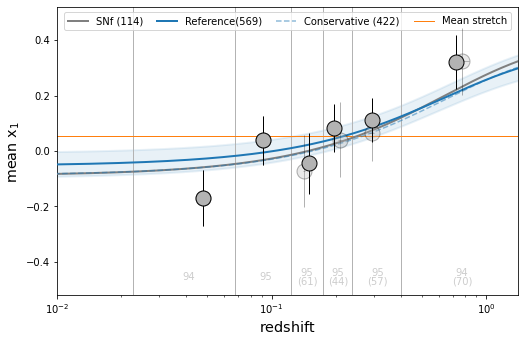

In [37]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop2 = dict(marker="o", ms=15, ecolor="0.7", mew=1, mec="0.5")
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

cmap = 'inferno'

#vmap_v = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color="0.7", lw=1)

#############################################################################################

if mean_c.value == 'mean':
    vmap_s = plt.cm.get_cmap(cmap)(np.linspace(0, 1, 6))
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean[i], x1_comp_mean[i],
                    xerr = z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                    yerr = x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])),
                    color=vmap_s[i], **prop, zorder=10, lw=1)
else:
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean[i], x1_comp_average[i],
                    xerr = z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                    yerr = x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])),
                    color=vmap_s[i], **prop, zorder=10, lw=1)


ax.plot(zlin, age_law_snf(zlin),
        color="0.5", lw=2, ls='-',
        label='SNf (114)', zorder=6)

#ax.fill_between(zlin, age_law_snf(zlin) + models_std_snf,
#                age_law_snf(zlin) - models_std_snf,
#                color="0.5", alpha=.1, lw=2)

ax.plot(zlin, age_law_all(zlin),
        color="C0", lw=2,
        label='Reference(569)', zorder=8)
##        label='Age-drift Model', zorder=8)

ax.fill_between(zlin, age_law_all(zlin) + models_std,
                age_law_all(zlin) - models_std,
                color="C0", alpha=.1, lw=2)

#ax.plot(zlin, age_law_all_nsnf(zlin),
#        color="0.5", lw=1, ls='-.',
#        label='All but SNf (455)', zorder=8)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

#############################################################################################

if mean_c.value == 'mean':
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean_cons[i], x1_comp_mean_cons[i],
                     xerr=z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
                     yerr=x1_comp_std_cons[i]/np.sqrt(len(df_c.stretchs.values[slices_cons[i]])),
                     color=vmap_s[i], **prop, alpha=.3, zorder=9, lw=1)

else:
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean_cons[i], x1_comp_average_cons[i],
                     xerr = z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
                     yerr = x1_comp_std_cons[i]/np.sqrt(len(df_c.stretchs.values[slices_cons[i]])),
                     color=vmap_s[i], **prop, alpha=.3, zorder=9, lw=1)

ax.plot(zlin, age_law_all_cons(zlin),
        color="C0", lw=1.5, ls='--', alpha=.5,
        label='Conservative (422)', zorder=7)

#############################################################################################

if mean_c.value == 'mean':
    ax.hline(evol1G1M1S.param['mu'], color='C1', lw=1, ls='-', label='Mean stretch')
    #ax.hline(np.mean(df_nc.stretchs), color='C1', lw=1, ls='-', label='Mean stretch')

else:
    ax.hline(np.average(df_nc.stretchs,
                        weights=1/(df_nc.stretchs**2 +
                                   minimize('stretchs', 'nc', 'all')[1][1]['value']**2)),
             color='C1', lw=1, ls='-', label='Weighted stretch')

#############################################################################################

for i in range(6):
    if len(df_nc.redshifts.values[slices[i]]) == len(df_c.redshifts.values[slices_cons[i]]):
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.465,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
    else:
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.45,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][1], -0.48,
                '(' + str(len(df_c.redshifts.values[slices_cons[i]])) + ')', alpha=.2)

#############################################################################################

ax.set_ylim(-0.52, 0.52)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

ax.legend(ncol=4, loc='upper center', columnspacing=1.4)

fig.savefig(f'../../../Images/pdf/stretchevol_all_vs_snf-{mean_c.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/stretchevol_all_vs_snf-{mean_c.value}.png', bbox_inches='tight', dpi=600)

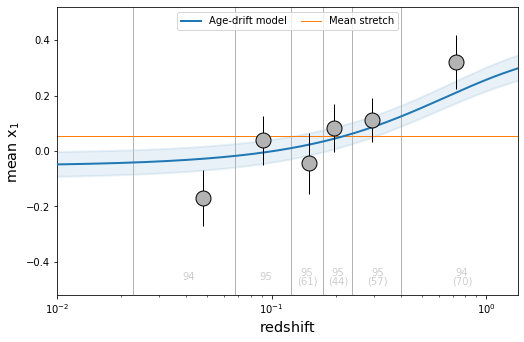

In [44]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop2 = dict(marker="o", ms=15, ecolor="0.7", mew=1, mec="0.5")
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

cmap = 'inferno'

#vmap_v = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color="0.7", lw=1)

#############################################################################################

if mean_c.value == 'mean':
    vmap_s = plt.cm.get_cmap(cmap)(np.linspace(0, 1, 6))
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean[i], x1_comp_mean[i],
                    xerr = z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                    yerr = x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])),
                    color=vmap_s[i], **prop, zorder=10, lw=1)
else:
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean[i], x1_comp_average[i],
                    xerr = z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                    yerr = x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])),
                    color=vmap_s[i], **prop, zorder=10, lw=1)

ax.plot(zlin, age_law_all(zlin),
        color="C0", lw=2,
        #label='Reference(569)', zorder=8)
        label='Age-drift model', zorder=8)

ax.fill_between(zlin, age_law_all(zlin) + models_std,
                age_law_all(zlin) - models_std,
                color="C0", alpha=.1, lw=2)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

#############################################################################################

# if mean_c.value == 'mean':
#     for i, c in zip(range(6), vmap_s):
#         ax.errorbar(z_comp_mean_cons[i], x1_comp_mean_cons[i],
#                      xerr=z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
#                      yerr=x1_comp_std_cons[i]/np.sqrt(len(df_c.stretchs.values[slices_cons[i]])),
#                      color=vmap_s[i], **prop, alpha=.3, zorder=9, lw=1)
# 
# else:
#     for i, c in zip(range(6), vmap_s):
#         ax.errorbar(z_comp_mean_cons[i], x1_comp_average_cons[i],
#                      xerr = z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
#                      yerr = x1_comp_std_cons[i]/np.sqrt(len(df_c.stretchs.values[slices_cons[i]])),
#                      color=vmap_s[i], **prop, alpha=.3, zorder=9, lw=1)

#############################################################################################

if mean_c.value == 'mean':
    ax.hline(evol1G1M1S.param['mu'], color='C1', lw=1, ls='-', label='Mean stretch')
    #ax.hline(np.mean(df_nc.stretchs), color='C1', lw=1, ls='-', label='Mean stretch')

else:
    ax.hline(np.average(df_nc.stretchs,
                        weights=1/(df_nc.stretchs**2 +
                                   minimize('stretchs', 'nc', 'all')[1][1]['value']**2)),
             color='C1', lw=1, ls='-', label='Weighted stretch')

#############################################################################################

for i in range(6):
    if len(df_nc.redshifts.values[slices[i]]) == len(df_c.redshifts.values[slices_cons[i]]):
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.465,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
    else:
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.45,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][1], -0.48,
                '(' + str(len(df_c.redshifts.values[slices_cons[i]])) + ')', alpha=.2)

#############################################################################################

ax.set_ylim(-0.52, 0.52)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

ax.legend(ncol=4, loc='upper center', columnspacing=1.4)

fig.savefig(f'../../../Images/pdf/stretchevol_all_nocons-{mean_c.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/stretchevol_all_nocons-{mean_c.value}.png', bbox_inches='tight', dpi=600)